## Processing User Data with the New Fields ##

In [2]:
# install the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta

Data generation complete with 770886 records.


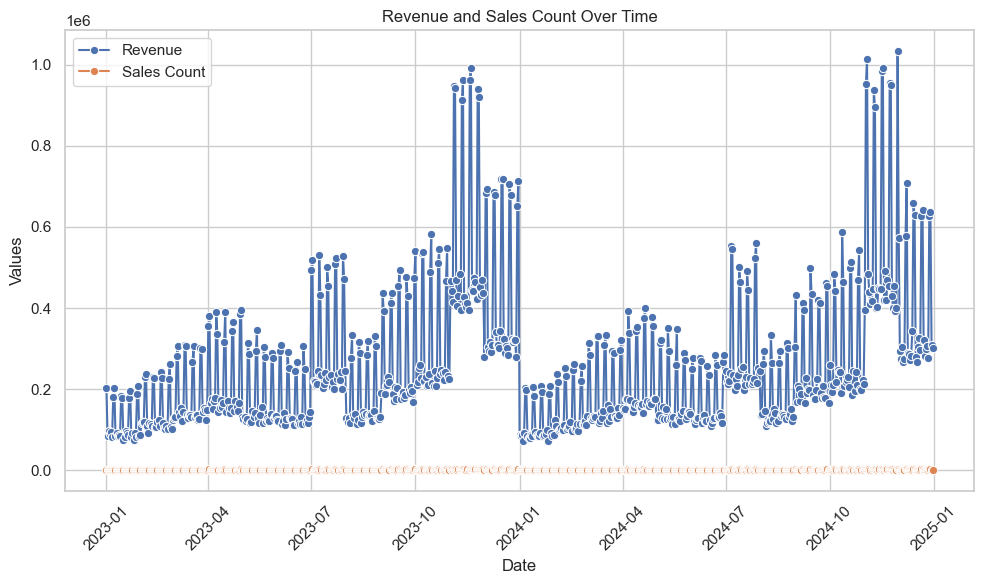

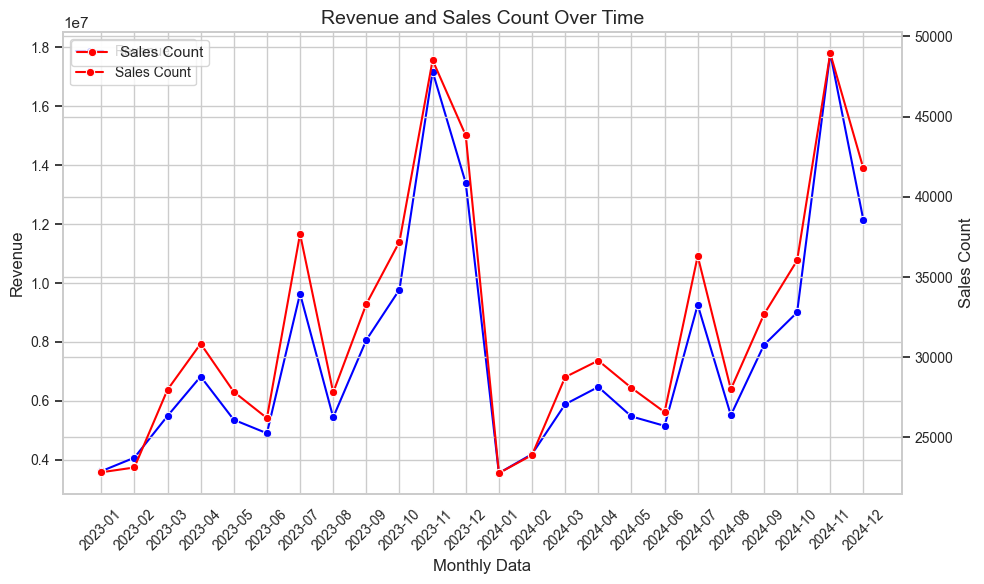

In [3]:
import import_ipynb
import User_Data_Generation
userdata = User_Data_Generation.users

In [4]:
# Process data: convert fields into the right data types

user_data = userdata.copy()
user_data["timestamp"] = pd.to_datetime(user_data["timestamp"])

# add new date column 

user_data["Date"] = pd.to_datetime(user_data["timestamp"]).dt.normalize()

In [5]:
user_data.head()

,timestamp,user_id,action,category,product_name,price,Date
0,2023-01-01 01:05:35,7d86c016-ae56-418b-8119-e1412e7b5db2,"click, purchase",Books,To Kill a Mockingbird,20.84,2023-01-01
1,2023-01-01 23:29:15,7bd0ee5e-59b4-4947-bbbf-f0beebdcebbd,purchase,Home,Vacuum Cleaner,217.32,2023-01-01
2,2023-01-01 22:36:05,277f10c2-1e9c-47a4-817f-fbf0bb257aa2,"view, purchase",Electronics,Gaming Console,522.31,2023-01-01
3,2023-01-01 10:23:45,f0fb5ab4-0c62-43ce-bf92-7a79897dad6f,purchase,Clothing,Dress,99.79,2023-01-01
4,2023-01-01 13:43:28,dee65a5b-6428-4644-b1e7-789a45eb9497,"click, purchase",Electronics,TV,805.19,2023-01-01


In [6]:
# Tackling "Action" field: extracting user actions to define attribution 

# Function to extract interactions
def extract_interactions(history, position):
    # Split the history string into a list
    entries = history.split(", ")
    # Check if the requested position exists (from the end)
    if len(entries) >= position:
        return entries[-position]
    return None  # Return None if the position doesn't exist

# Apply the function to create the columns
user_data["Last Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 1))
user_data["Third Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 2))
user_data["Second Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 3))
user_data["First Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 4))

In [7]:
# Create a new field "Sales_Channel" for attribution & further insights on the MMM

# Define probabilities for Sales_Channel when Last Interaction is "purchase"
sales_channel_probs = {
    "Search": 0.4,
    "Social": 0.25,
    "Video": 0.15,
    "Display": 0.10,
    "Digital Audio": 0.10
}

# Function to determine Sales_Channel
def determine_sales_channel(last_interaction):
    if last_interaction in ["view", "click"]:
        return "Offline"
    else:
        return np.random.choice(
            list(sales_channel_probs.keys()), 
            p=list(sales_channel_probs.values())
        )

# Apply the function to create the Sales_Channel column
user_data["Sales_Channel"] = user_data["Last Interaction"].apply(determine_sales_channel)

In [8]:
# Testing a new function in a copied dataframe
user_data2 = user_data.copy()

# Getting view counts and click counts out of the action section

click_probs = [0.35, 0.25, 0.15, 0.15, 0.1] # Search > Social > Video > Display > Audio
view_probs = [0.1, 0.2, 0.25, 0.3, 0.15]  # Display > Social > Video > Search > Audio
categories = ["Search", "Social", "Video", "Display", "Audio"]

# Function to distribute actions
def distribute_actions(actions):
    purchases = actions.count("purchase")
    clicks = actions.count("click") + purchases  # Purchases include 1 click each
    views = actions.count("view") + clicks  # Clicks (and purchases) include 1 view each
    
    # Distribute views and clicks based on probabilities
    view_distribution = np.random.multinomial(views, view_probs)
    click_distribution = np.random.multinomial(clicks, click_probs)
    
    # Create output dictionary
    output = {f"{category}_Views": view_distribution[i] for i, category in enumerate(categories)}
    output.update({f"{category}_Clicks": click_distribution[i] for i, category in enumerate(categories)})
    return output

# Apply the function and expand the result into new columns
distributions = user_data2["action"].apply(distribute_actions)
distributions_user_data2 = pd.DataFrame(list(distributions))

# Add the new columns to the original DataFrame
user_data3 = pd.concat([user_data2, distributions_user_data2], axis=1)

In [9]:
# Feature Engineering

user_data3["Sales_Channel"].unique() # checking the number of unique values in Sales Channel
user_data3["category"].unique() # checking the number of unique values in Category
user_data4 = user_data3.copy()

# Import scikit-learn for OHE

from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop=None, sparse_output=False)

# OneHotEncode "category"
category_encoded = encoder.fit_transform(user_data4[["category"]])
category_col_encoded = encoder.get_feature_names_out(["category"])
user_data4[category_col_encoded] = category_encoded  # Add encoded columns without removing the original

# OneHotEncode "Sales_Channel"
saleschannel_encoded = encoder.fit_transform(user_data4[["Sales_Channel"]])
sales_cha_encoded = encoder.get_feature_names_out(["Sales_Channel"])
user_data4[sales_cha_encoded] = saleschannel_encoded  # Add encoded columns without removing the original

# Display updated columns
print(user_data4.columns)


Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')


In [10]:
ud = user_data4
ud.head()
ud.columns

Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')

## Joining User Data with the Macro & Spend Data ##

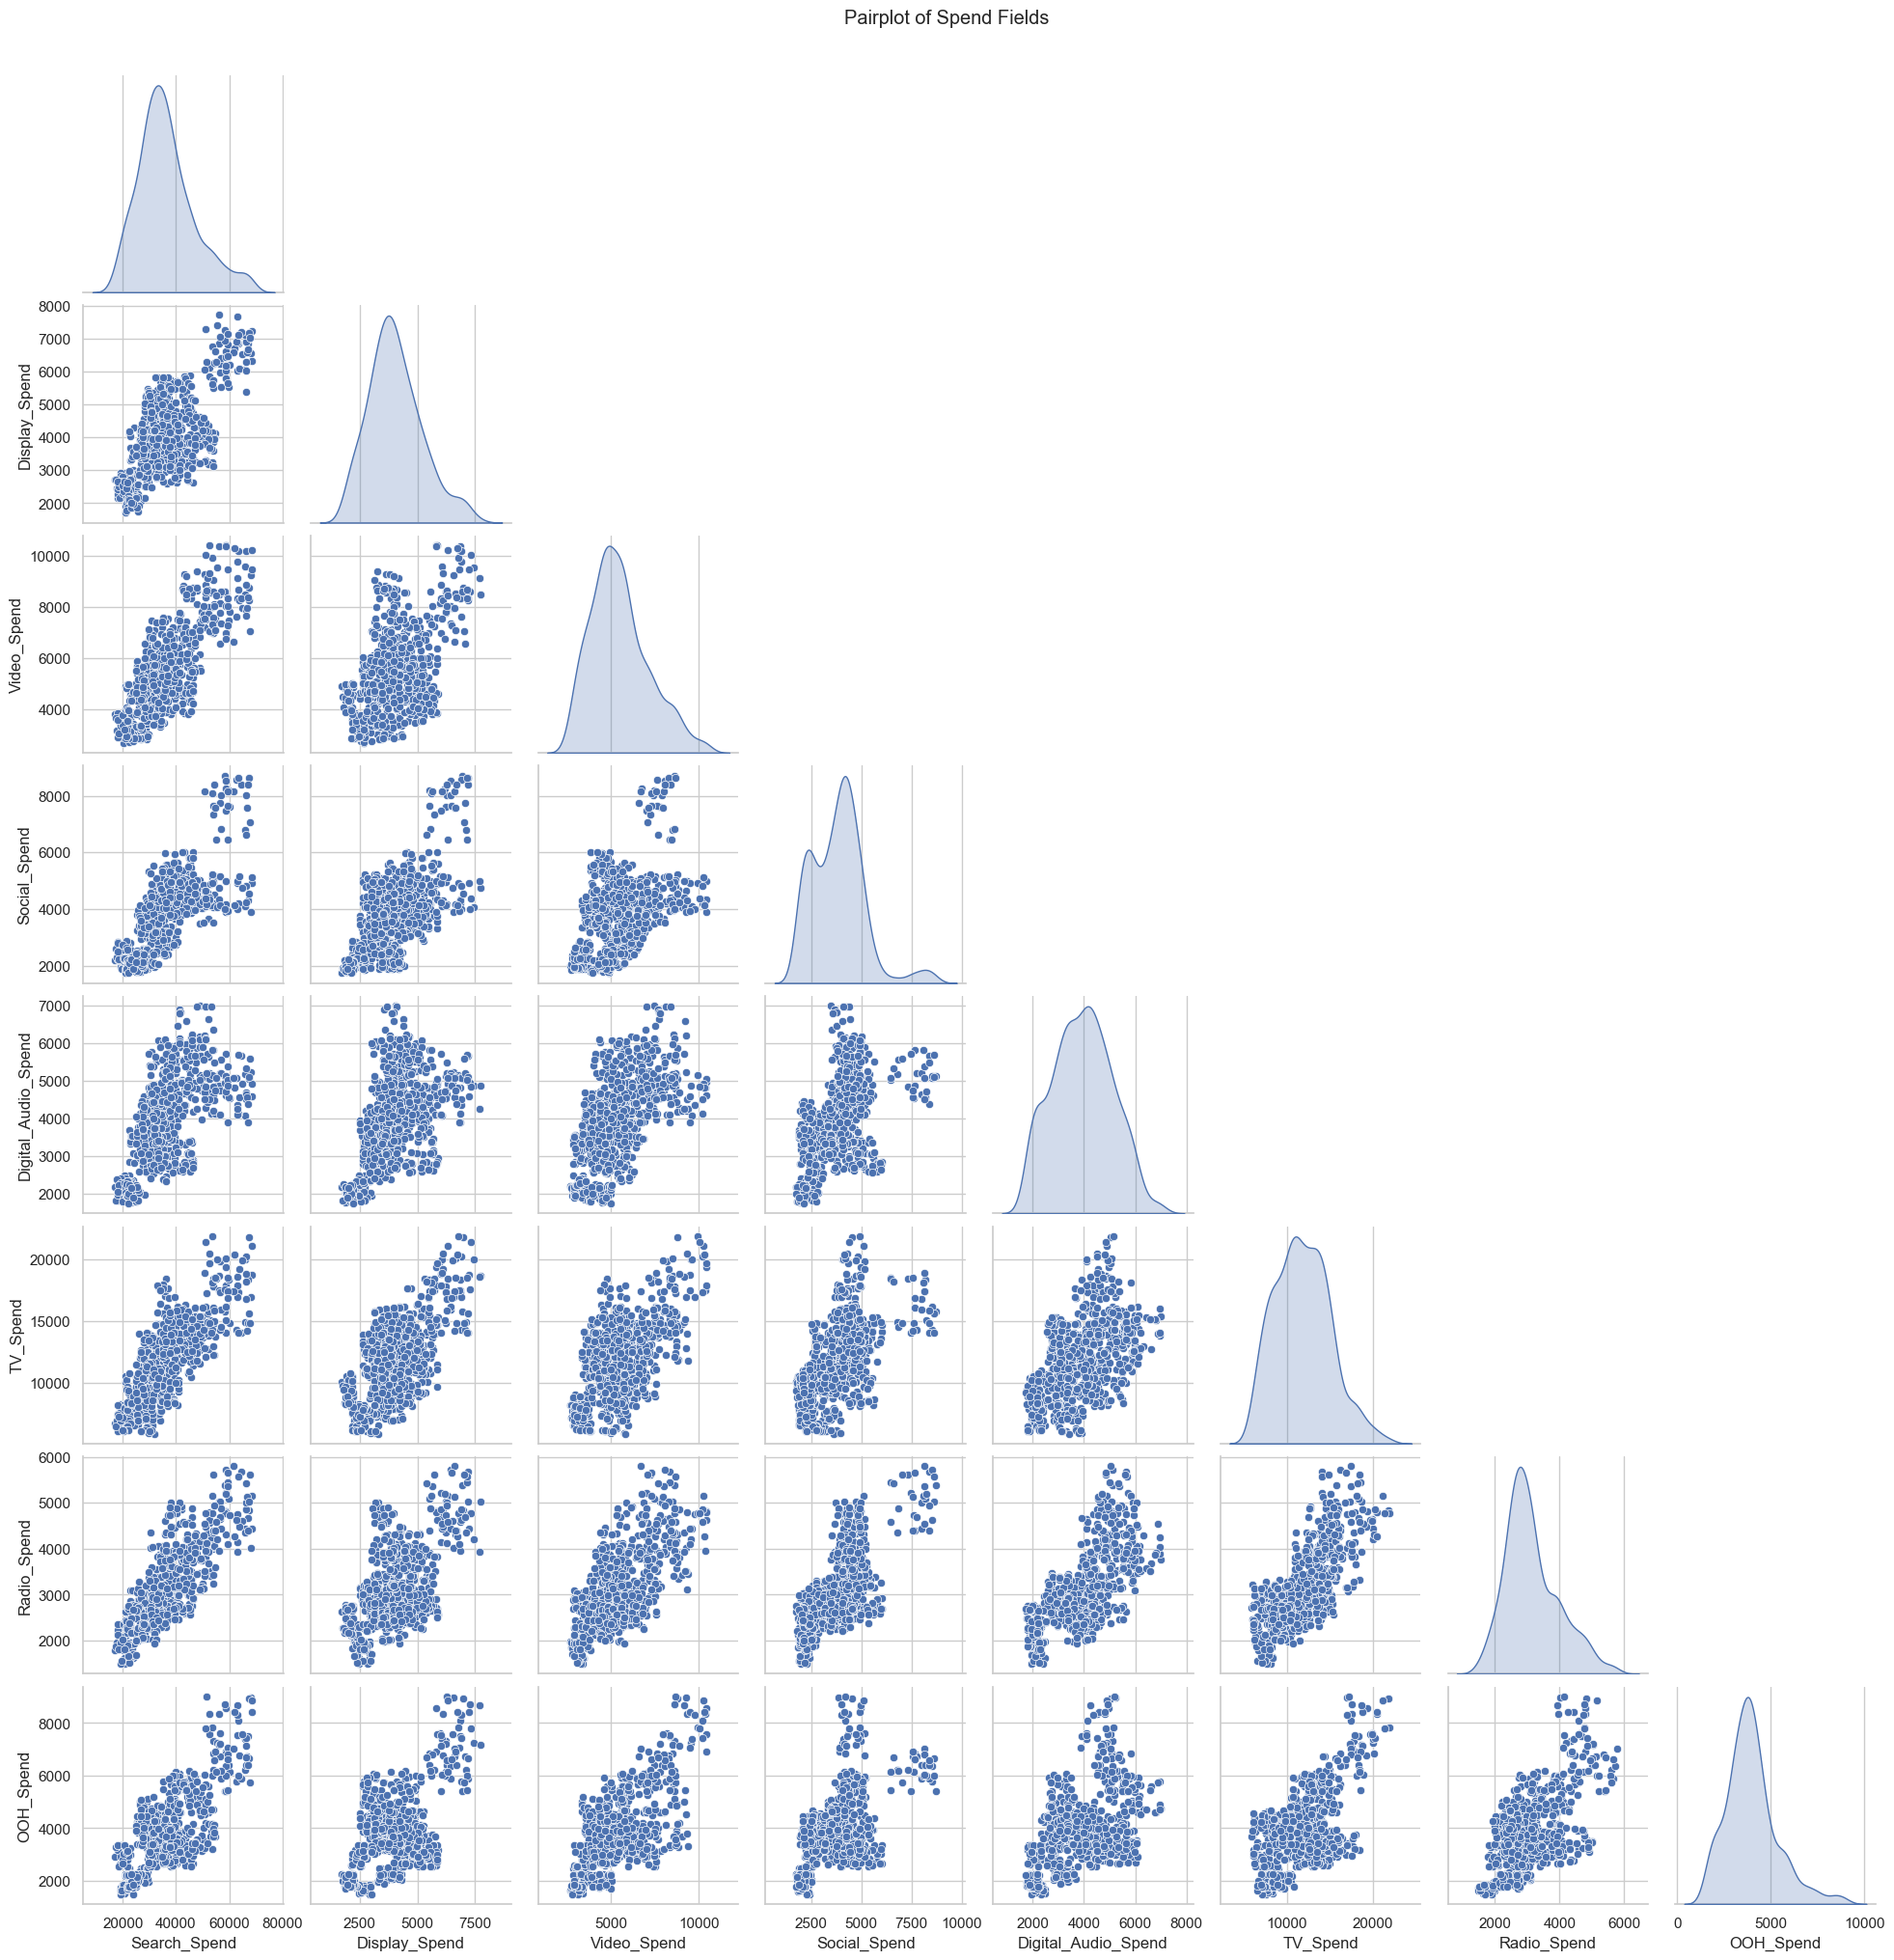

/Users/veyselsonmez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/veyselsonmez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/veyselsonmez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

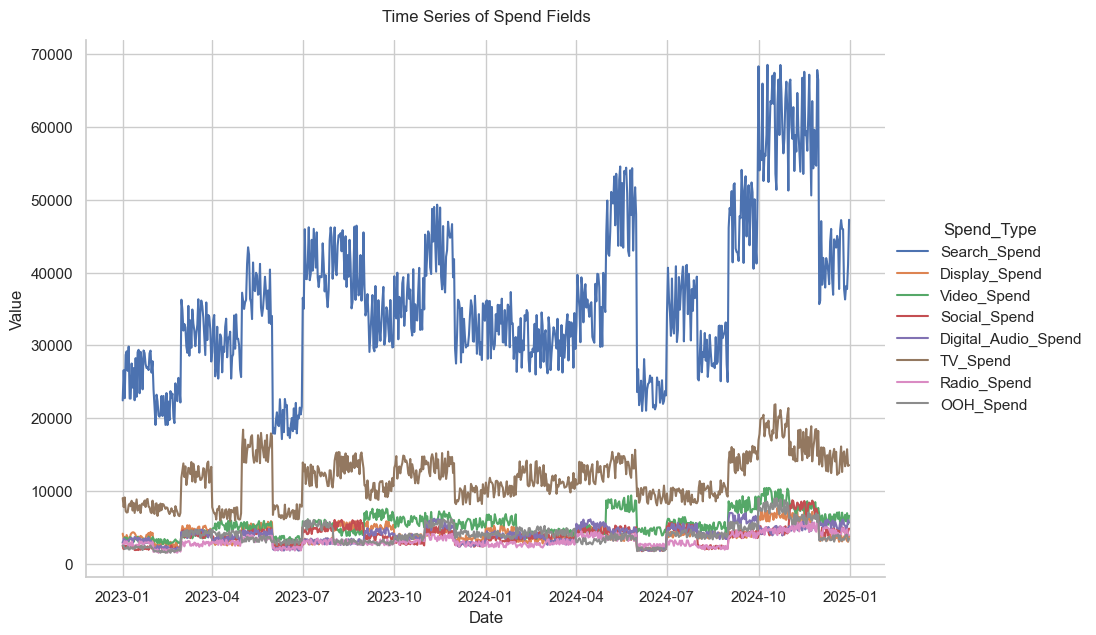

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  731 non-null    datetime64[ns]
 1   Month                 731 non-null    int64         
 2   Year                  731 non-null    int64         
 3   Weekday               731 non-null    int64         
 4   Trend_Factor          731 non-null    float64       
 5   Promo_Exists          731 non-null    int64         
 6   Consumer_Index        731 non-null    float64       
 7   Inflation_Rate        731 non-null    float64       
 8   Budget_Factor         731 non-null    int64         
 9   Search_Factor         731 non-null    float64       
 10  Display_Factor        731 non-null    float64       
 11  Video_Factor          731 non-null    float64       
 12  Social_Factor         731 non-null    float64       
 13  Digital_Audio_Factor

In [11]:
# importing other notebook to join macro table with the user data

import import_ipynb
import MMM_macro_data 
daily = MMM_macro_data.daily

In [13]:
# Bringing the sum of revenue and sales on a daily rollup 

# Define the feature fields for summation
feature_engineered_sum = [
    'Search_Views', 'Social_Views', 'Video_Views', 'Display_Views', 'Audio_Views',
    'Search_Clicks', 'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
    'category_Books', 'category_Clothing', 'category_Electronics', 'category_Home',
    'Sales_Channel_Digital Audio', 'Sales_Channel_Display', 'Sales_Channel_Offline',
    'Sales_Channel_Search', 'Sales_Channel_Social', 'Sales_Channel_Video'
]

# Base aggregation dictionary
agg_dictionary = {
    "revenue": ("price", "sum"),
    "salescount": ("user_id", "count"),
    "searchclicks": ("Search_Clicks", "sum"),
    "search_impr": ("Search_Views", "sum")
}

# Update the dictionary dynamically for all feature fields
agg_dictionary.update({field: (field, "sum") for field in feature_engineered_sum})


# Perform groupby operation
ud_join = ud.groupby("Date").agg(**agg_dictionary)

# check the values

ud_join.head()

,revenue,salescount,searchclicks,search_impr,Search_Views,Social_Views,Video_Views,Display_Views,Audio_Views,Search_Clicks,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,203062.20,1005,854,364,364,714,897,1141,520,854,...,214.0,247.0,253.0,291.0,92.0,103.0,42.0,390.0,231.0,147.0
2023-01-02,84258.68,625,641,285,285,637,829,964,493,641,...,173.0,160.0,156.0,136.0,50.0,58.0,71.0,214.0,150.0,82.0
2023-01-03,96597.14,687,695,326,326,627,845,1014,502,695,...,170.0,153.0,184.0,180.0,62.0,61.0,72.0,225.0,175.0,92.0
2023-01-04,88125.67,640,646,316,316,607,792,888,511,646,...,178.0,152.0,167.0,143.0,45.0,55.0,68.0,225.0,157.0,90.0
2023-01-05,93290.63,699,685,369,369,724,899,1089,477,685,...,162.0,188.0,166.0,183.0,61.0,55.0,89.0,224.0,167.0,103.0


In [15]:
mmm_1 = daily.merge(ud_join, on = "Date", how="left") # Joining the user data with the macro data

In [16]:
# Macro data exploration

mmm_1.head()


,Date,Month,Year,Weekday,Trend_Factor,Promo_Exists,Consumer_Index,Inflation_Rate,Budget_Factor,Search_Factor,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,1,2023,6,1.05,0,110.7,8.7,1554983,0.48,...,214.0,247.0,253.0,291.0,92.0,103.0,42.0,390.0,231.0,147.0
1,2023-01-02,1,2023,0,1.05,0,110.7,8.7,1554983,0.48,...,173.0,160.0,156.0,136.0,50.0,58.0,71.0,214.0,150.0,82.0
2,2023-01-03,1,2023,1,1.05,0,110.7,8.7,1554983,0.48,...,170.0,153.0,184.0,180.0,62.0,61.0,72.0,225.0,175.0,92.0
3,2023-01-04,1,2023,2,1.05,0,110.7,8.7,1554983,0.48,...,178.0,152.0,167.0,143.0,45.0,55.0,68.0,225.0,157.0,90.0
4,2023-01-05,1,2023,3,1.05,0,110.7,8.7,1554983,0.48,...,162.0,188.0,166.0,183.0,61.0,55.0,89.0,224.0,167.0,103.0


## MMM Joined Table EDA

In [17]:
mmm_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         731 non-null    datetime64[ns]
 1   Month                        731 non-null    int64         
 2   Year                         731 non-null    int64         
 3   Weekday                      731 non-null    int64         
 4   Trend_Factor                 731 non-null    float64       
 5   Promo_Exists                 731 non-null    int64         
 6   Consumer_Index               731 non-null    float64       
 7   Inflation_Rate               731 non-null    float64       
 8   Budget_Factor                731 non-null    int64         
 9   Search_Factor                731 non-null    float64       
 10  Display_Factor               731 non-null    float64       
 11  Video_Factor                 731 non-null    

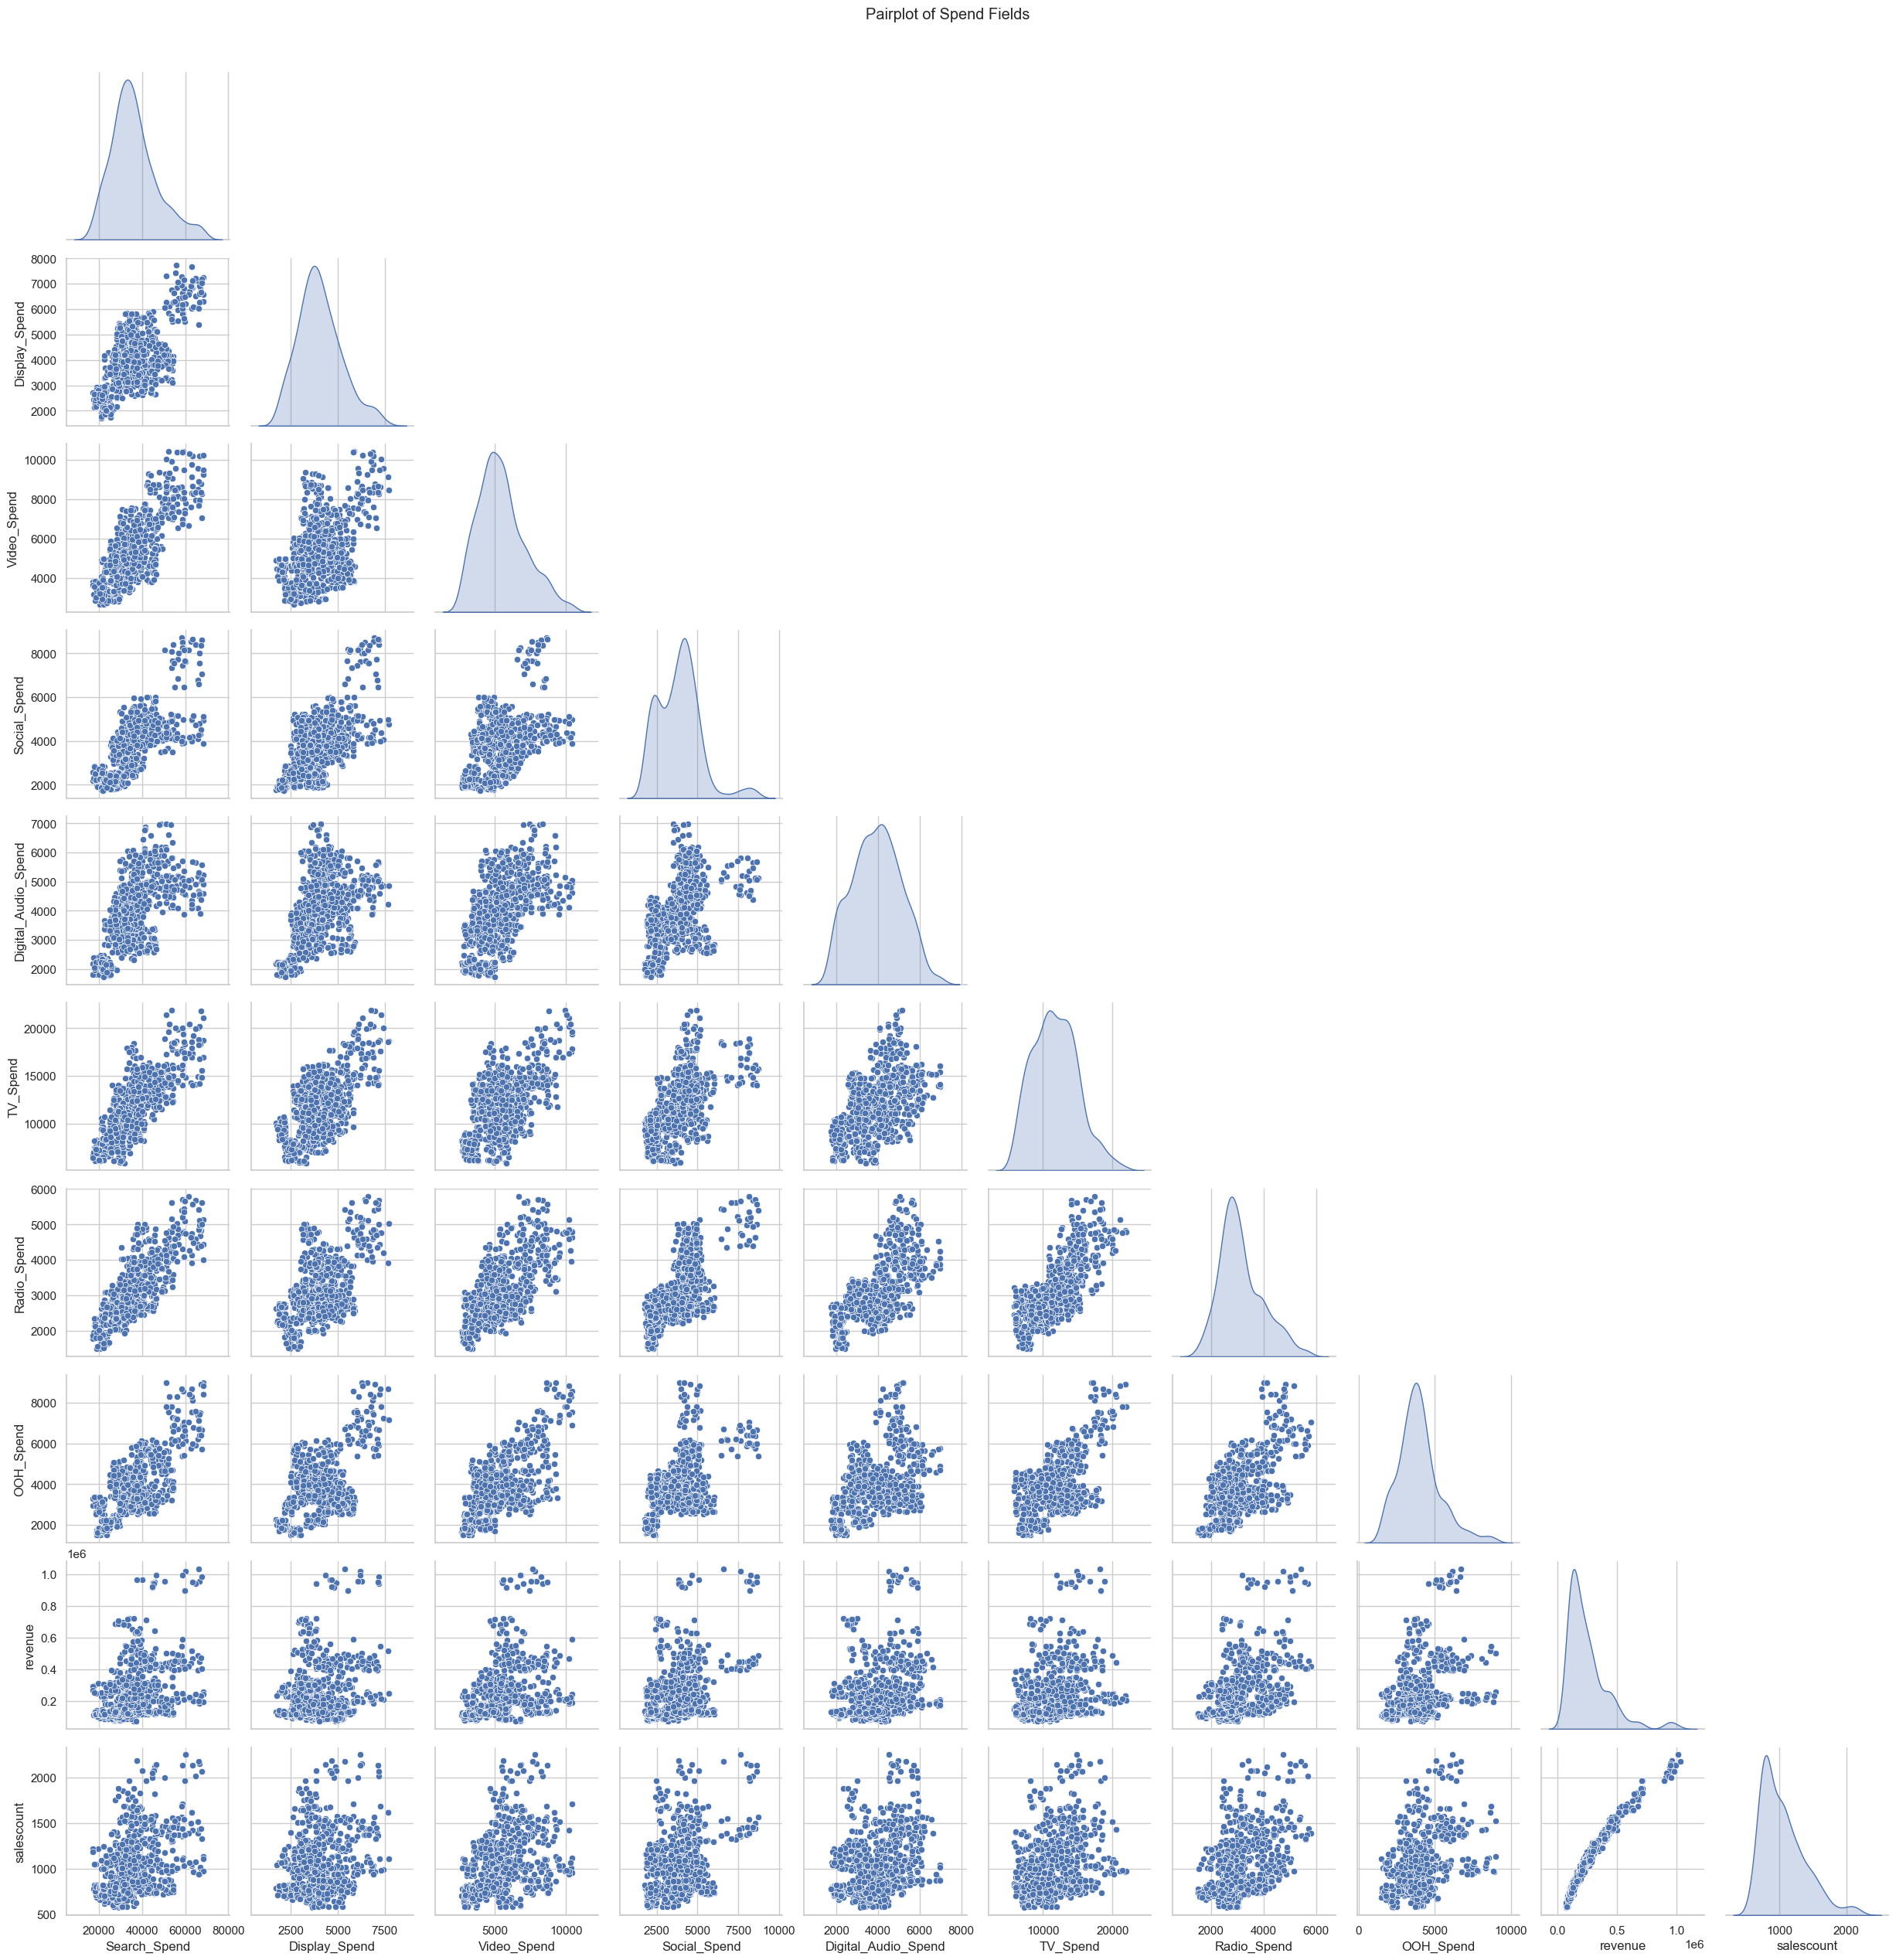

In [18]:
# Checking correlation & distribution

# Filter columns that contain 'Spend' in their names
spendc = [col for col in mmm_1.columns if "Spend" in col] + ["revenue", "salescount"]

# Create pairplot
sns.pairplot(mmm_1[spendc], diag_kind="kde", corner=True, height=2.5)

# Show the plot
plt.suptitle("Pairplot of Spend Fields", y=1.02)
plt.show()

In [ ]:
# Ensure correct syntax with explicit data parameter
sns.lineplot(data=mmm_1, x="Date", y="salescount")
plt.title("Sales Count Over Time")
plt.xlabel("Date")
plt.ylabel("Sales Count")
plt.xticks(rotation=45)
plt.show()

# Final Table

In [19]:
# Drop columns containing "Factor" and specific columns 'searchclicks' and 'search_impr' to prevent data leakage

mmm_2 = mmm_1.copy()

mmm_2_columns_to_drop = [col for col in mmm_2.columns if "Factor" in col] + ['searchclicks', 'search_impr']
mmm_2 = mmm_2.drop(columns=mmm_2_columns_to_drop)

mmm_3 = mmm_2.copy()

mmm_3.head()

,Date,Month,Year,Weekday,Promo_Exists,Consumer_Index,Inflation_Rate,Search_Spend,Display_Spend,Video_Spend,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,1,2023,6,0,110.7,8.7,22435.057112,4127.812657,2953.287449,...,214.0,247.0,253.0,291.0,92.0,103.0,42.0,390.0,231.0,147.0
1,2023-01-02,1,2023,0,0,110.7,8.7,26586.604885,3403.497811,2834.696870,...,173.0,160.0,156.0,136.0,50.0,58.0,71.0,214.0,150.0,82.0
2,2023-01-03,1,2023,1,0,110.7,8.7,22733.632249,3687.777836,3608.282411,...,170.0,153.0,184.0,180.0,62.0,61.0,72.0,225.0,175.0,92.0
3,2023-01-04,1,2023,2,0,110.7,8.7,28691.936232,3405.229166,3251.475999,...,178.0,152.0,167.0,143.0,45.0,55.0,68.0,225.0,157.0,90.0
4,2023-01-05,1,2023,3,0,110.7,8.7,29172.794649,3938.608992,3583.450148,...,162.0,188.0,166.0,183.0,61.0,55.0,89.0,224.0,167.0,103.0


0     2023-01-01
1     2023-01-01
2     2023-01-01
3     2023-01-01
4     2023-01-01
         ...    
726   2024-12-01
727   2024-12-01
728   2024-12-01
729   2024-12-01
730   2024-12-01
Name: Month_Year, Length: 731, dtype: datetime64[ns]

In [20]:
# Monthly Data

import pandas as pd

# Convert Month, Year into date format and Weekday into string
mmm_3["Month_Year"] = pd.to_datetime(mmm_3[["Year", "Month"]].assign(Day=1))
mmm_3["Weekday"] = mmm_3["Weekday"].astype(str)

# Group the table by Month_Year
grouped_columns = {
    "Promo_Exists": "mean",
    "Consumer_Index": "mean",
    "Inflation_Rate": "mean",
}

# Add all other numeric columns with sum
for col in mmm_3.select_dtypes(include="number").columns:
    if col not in grouped_columns:
        grouped_columns[col] = "sum"

# Group and aggregate
mmm_monthly = mmm_3.groupby("Month_Year").agg(grouped_columns).reset_index()

# Output the resulting monthly table
mmm_monthly

,Month_Year,Promo_Exists,Consumer_Index,Inflation_Rate,Month,Year,Search_Spend,Display_Spend,Video_Spend,Social_Spend,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,0.0,110.7,8.7,31,62713,8.246099e+05,117040.445268,100497.941217,68382.985931,...,5729.0,5614.0,5739.0,5749.0,2086.0,2017.0,1908.0,8277.0,5294.0,3249.0
1,2023-02-01,0.0,111.1,8.7,56,56644,6.131077e+05,72712.434242,85154.585306,59350.960340,...,5843.0,5842.0,5798.0,5647.0,2147.0,2071.0,1979.0,8369.0,5334.0,3230.0
2,2023-03-01,0.0,112.5,7.4,93,62713,1.008395e+06,146475.816275,125948.681517,125469.166942,...,7021.0,6988.0,7058.0,6912.0,2599.0,2623.0,2462.0,10134.0,6411.0,3750.0
3,2023-04-01,1.0,113.0,7.2,120,60690,8.969467e+05,87342.730818,156347.248586,103991.000056,...,7650.0,7827.0,7633.0,7736.0,2942.0,2972.0,1141.0,11893.0,7399.0,4499.0
4,2023-05-01,0.0,113.2,6.1,155,62713,1.155904e+06,158145.843151,159597.196085,134332.838197,...,6872.0,7055.0,6930.0,6990.0,2550.0,2606.0,2452.0,10203.0,6322.0,3714.0
5,2023-06-01,0.0,113.4,6.4,180,60690,5.921566e+05,73518.652706,101860.044175,75520.189375,...,6417.0,6595.0,6562.0,6636.0,2344.0,2360.0,2262.0,9676.0,6035.0,3533.0
6,2023-07-01,1.0,112.6,6.2,217,62713,1.264481e+06,94476.299260,167319.516678,145016.149547,...,9575.0,9621.0,9218.0,9275.0,3717.0,3580.0,1259.0,14501.0,9163.0,5469.0
7,2023-08-01,0.0,113.2,6.1,248,62713,1.286285e+06,163066.240516,136770.607217,165266.856218,...,6877.0,7068.0,6962.0,6900.0,2571.0,2472.0,2404.0,10150.0,6414.0,3796.0
8,2023-09-01,1.0,114.1,4.5,270,60690,9.952768e+05,152238.303913,201115.912837,111750.488515,...,8253.0,8349.0,8372.0,8344.0,3166.0,3221.0,1198.0,12834.0,7995.0,4904.0
9,2023-10-01,1.0,114.6,3.8,310,62713,1.106473e+06,114601.110700,180953.434332,88605.251974,...,9148.0,9347.0,9470.0,9240.0,3595.0,3602.0,1311.0,14241.0,9016.0,5440.0


In [ ]:
# Turn Monthly Data into CSV to use it in different models such as LightweightMMM & PyMC 

mmm_monthly.to_csv("monthly_data.csv", index=False)

# Marketing Mix Modelling: Baseline Model

#### Simple Baseline Model

Below is the simple baseline model based on the linear regression.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

# Prepare the data
# Assuming `mmm_monthly` is the grouped monthly DataFrame from the previous step

# Define predictors (X) and target variable (y)
predictors = [
    "Promo_Exists", "Consumer_Index", "Inflation_Rate", "Search_Spend",
    "Display_Spend", "Video_Spend", "Social_Spend", "Digital_Audio_Spend",
    "TV_Spend", "Radio_Spend", "OOH_Spend", "Gross_Rating_Point",
    "Sales_Channel_Digital Audio", "Sales_Channel_Display",
    "Sales_Channel_Offline", "Sales_Channel_Search", "Sales_Channel_Social",
    "Sales_Channel_Video", "Search_Views", "Social_Views", "Video_Views",
    "Display_Views", "Audio_Views", "Search_Clicks", "Social_Clicks",
    "Video_Clicks", "Display_Clicks", "Audio_Clicks", "category_Books",
    "category_Clothing", "category_Electronics", "category_Home"
]

target = "revenue"

# Apply MinMaxScaler to selected columns
scaler_columns = [col for col in predictors if 
                  "_Views" in col or "_Clicks" in col or "category_" in col or "Sales_Channel_" in col]
scaler = MinMaxScaler()
mmm_monthly[scaler_columns] = scaler.fit_transform(mmm_monthly[scaler_columns])

X = mmm_monthly[predictors]
y = mmm_monthly[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print evaluation metrics
print("Linear Regression Model Evaluation:")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

# Display the coefficients
coefficients = pd.DataFrame({
    "Feature": predictors,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Coefficients:")
print(coefficients)

# Add predictions to the DataFrame for further analysis
mmm_monthly["predicted_revenue"] = model.predict(X)

# Display a sample of the updated DataFrame
print("\nUpdated DataFrame with Predictions:")
print(mmm_monthly[["Month", "Year", "revenue", "predicted_revenue"]].head())

In [ ]:
# Plot: Actual vs. Predicted Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title("Actual vs. Predicted Revenue")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.legend()
plt.tight_layout()
plt.show()

### Baseline Model: Lasso

In [ ]:
# Lasso Model

from sklearn.linear_model import Lasso

# Apply Lasso Regularization
alpha = 100  # Adjust for optimal performance
lasso_model = Lasso(alpha=alpha, random_state=42)
lasso_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_lasso = lasso_model.predict(X_test)

# Calculate metrics
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso)


print("Lasso Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse_lasso:.2f}")
print(f"R-squared (R²): {r2_lasso:.2f}")
print(f"RMSE): {rmse_lasso:.2f}")
print(f"MAPE: {mape_lasso:.2f}")

# Display coefficients
coefficients = pd.DataFrame({
    "Feature": predictors,
    "Coefficient": lasso_model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Coefficients (Lasso):")
print(coefficients)

# Add predictions to the DataFrame
mmm_monthly["predicted_revenue_lasso"] = lasso_model.predict(X)

## XG Boost Based MMM

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=1000,             # Number of boosting rounds
    learning_rate=0.05,             # Learning rate
    max_depth=5,                    # Maximum tree depth
    subsample=0.8,                   # Subsample ratio
    colsample_bytree=0.8,             # Column sampling
    random_state=42,
    early_stopping_rounds=10
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("XGBoost Model Evaluation:")
print(f"R-squared (R²): {r2_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2%}")

# Feature importance plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type="weight")
plt.title("Top 10 Feature Importance")
plt.show()

# Add predictions to the original DataFrame
mmm_monthly["predicted_revenue_xgb"] = xgb_model.predict(X)

# Plot actual vs predicted revenue
plt.figure(figsize=(12, 6))
sns.lineplot(x=mmm_monthly['Month_Year'], y=mmm_monthly['revenue'], label='Actual Revenue', color='blue')
sns.lineplot(x=mmm_monthly['Month_Year'], y=mmm_monthly['predicted_revenue_xgb'], label='Predicted Revenue', color='red')
plt.title('Actual vs Predicted Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid()
plt.show()

NameError: name 'X_train' is not defined

# Random Forest Algorithm with Grid Search 

In addition to Linear Regression, Lasso model and the XGBoost which are instrumental to solve regression problems, Random Forest algorithm by picking the best estimator thanks to the Grid Search could be very instrumental to understand which marketing channel would perform the best in the context of an MMM.